# Tensorflow

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


Load data from csv files.
Image is provided as space separated values in 'Image' column.

In [2]:
def make_image(xs):
    a = np.fromstring(xs, sep=' ', dtype=np.float).reshape(96, 96)
    return a / 256

df = pd.read_csv('../data/training.csv', converters={'Image': make_image})
df['Image'].head()

0    [[0.9296875, 0.921875, 0.92578125, 0.9296875, ...
1    [[0.85546875, 0.83984375, 0.796875, 0.765625, ...
2    [[0.5625, 0.5546875, 0.62109375, 0.703125, 0.7...
3    [[0.75390625, 0.75, 0.75390625, 0.7578125, 0.7...
4    [[0.57421875, 0.578125, 0.625, 0.765625, 0.839...
Name: Image, dtype: object

## Select only few labels

In [3]:
labels = ['nose_tip_x', 'nose_tip_y']
train = df[labels + ['Image']].dropna()
print('All images: %d, with labels: %d' % (len(df), len(train)))

All images: 7049, with labels: 7049


## Show image

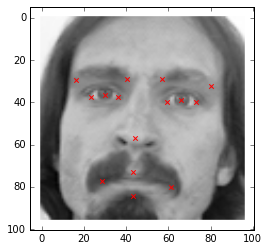

In [4]:
def show_image(row):
    plt.imshow(row.Image, cmap='Greys_r')
    xs = [row.left_eye_center_x, row.right_eye_center_x, row.left_eye_inner_corner_x, row.left_eye_outer_corner_x,
         row.right_eye_inner_corner_x, row.right_eye_outer_corner_x, row.left_eyebrow_inner_end_x, row.nose_tip_x,
         row.left_eyebrow_outer_end_x, row.right_eyebrow_inner_end_x, row.right_eyebrow_outer_end_x,
         row.mouth_left_corner_x, row.mouth_right_corner_x, row.mouth_center_top_lip_x, row.mouth_center_bottom_lip_x]
    ys = [row.left_eye_center_y, row.right_eye_center_y, row.left_eye_inner_corner_y, row.left_eye_outer_corner_y,
         row.right_eye_inner_corner_y, row.right_eye_outer_corner_y, row.left_eyebrow_inner_end_y, row.nose_tip_y,
         row.left_eyebrow_outer_end_y, row.right_eyebrow_inner_end_y, row.right_eyebrow_outer_end_y,
         row.mouth_left_corner_y, row.mouth_right_corner_y, row.mouth_center_top_lip_y, row.mouth_center_bottom_lip_y]
    plt.scatter(x=xs, y=ys, marker='x', color='red')
    
show_image(df.iloc[0])

## Build tensorflow model

### Evaluate score (RMSE)

In [5]:
def rmse(expected, predicted):
    p = tf.square(expected - predicted)
    ds = tf.reduce_mean(p, 1)
    return tf.sqrt(tf.reduce_mean(ds))

### Prepare Tensorflow model

Convert images read by pandas into ndarray

In [6]:
VECTOR_SIZE = 96*96
X = np.concatenate(train['Image'].apply(lambda x: np.reshape(x, VECTOR_SIZE)))
X = np.reshape(X, (len(train), VECTOR_SIZE))
print(X.shape)
Y = train[labels].as_matrix()
print(Y.shape)

(7049, 9216)
(7049, 2)


In [13]:
L1_COUNT = 100
# Create placeholders for image data and expected point positions
x_in = tf.placeholder(tf.float32, shape=[None, VECTOR_SIZE])
y_in = tf.placeholder(tf.float32, shape=[None, 2])

# Build neural network
def build_model(xs):
    W1 = tf.Variable(tf.truncated_normal([VECTOR_SIZE, L1_COUNT], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[L1_COUNT]))
    l1 = tf.nn.relu(tf.matmul(xs, W1) + b1)
    W2 = tf.Variable(tf.truncated_normal([L1_COUNT, 2], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[2]))
    return tf.matmul(l1, W2) + b2

# Define loss function
model = build_model(x_in)
loss = rmse(y_in, model)

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    for i in range(100):
        train_step.run(feed_dict={x_in: X, y_in: Y})
        if (i+1) % 10 == 0:
            score = loss.eval(feed_dict={x_in: X, y_in: Y})
            print('Epoch: %d, loss=%f' % (i+1, score))
    Y2 = model.eval(feed_dict={x_in: X})
Y2    

Epoch: 9, loss=54.632801
Epoch: 19, loss=52.631218
Epoch: 29, loss=6898.965820
Epoch: 39, loss=49.166161
Epoch: 49, loss=47.182522
Epoch: 59, loss=45.204899
Epoch: 69, loss=43.227543
Epoch: 79, loss=40.763435
Epoch: 89, loss=38.794071
Epoch: 99, loss=36.823635


array([[ 16.93089867,  21.82230759],
       [ 16.93089867,  21.82230759],
       [ 16.93089867,  21.82230759],
       ..., 
       [ 16.93089867,  21.82230759],
       [ 16.93089867,  21.82230759],
       [ 16.93089867,  21.82230759]], dtype=float32)

Now when we have trained model, lets check where it thinks a nose is

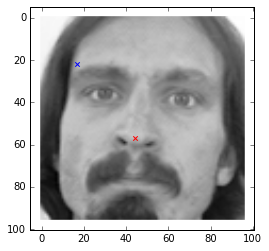

In [14]:
index = 0
plt.imshow(np.reshape(X[index], (96, 96)), cmap='Greys_r')
plt.scatter(x=Y[index][0], y=Y[index][1], marker='x', color='r')
plt.scatter(x=Y2[index][0], y=Y2[index][1], marker='x', color='b')